# 1. Introduction

## 1.1.  [Background]('https://en.wikipedia.org/wiki/Parsippany-Troy_Hills,_New_Jersey')

Parsippany-Troy Hills Township as known as Parsippany is one of the towns in Morris County New Jersey, United States. The name Parsippany comes from the Lenape Native American sub-tribe, which comes from the word parsipanong, which means "the place where the river winds through the valley". Since 2006, Parsippany-Troy Hills has been consistently recognized by Money magazine as one of the Best Places to Live in the United States. It is only 29 miles away from New York City.

The town is working destination of thousands of people as diversified manufacturing, polytechnic and Tech companies and tax firms are located here. Tiffany and Co., IBM, Deloitte, HNTB, ADP, Langan, Evonik, Allergan, B&G Foods, GAF Materials Corporation, IQVIA, Sun Chemical, Zoetis, Kings Food Markets, Lexus and Toyota Financial Services, American Financial Resources, Wyndham Worldwide and PNY Technologies, a manufacturer of computer memory devices, etc. are some popular working destination of people which are located in Parsippany-Troy Hills. The U.S. operations of Cadbury Adams, Reckitt Benckiser, Ricola and Safilo are located here. Cendant Corporation moved its headquarters to Parsippany-Troy Hills in 2001; in 2006 Cendant separated into several different companies, including Avis Budget Group, parent company of Avis Rent a Car System and Budget Rent a Car. This town is working destination for 1000s of people from New Jersey, New York and Pennsylvania states who commute every day for work.



## 1.2. Discussion of the  business problem

This town is a heart for working class-people from New Jersey and its neighboring states, New York, and Pennsylvania. There are 100s of restaurants in the town that feeds 1000s of those working-class people quick and healthy breakfast-lunch and even dinner. Today I am going to explore the restaurants which is within 4 miles of center of the town which typically serves breakfast and lunch. New Jersey is also home of ["Diners"]('https://www.nj.com/entertainment/2017/01/the_best_diner_in_each_of_new_jerseys_21_counties.html') which are classical American restaurants who serves delicious breakfast-lunch-dinner in a pleasant environment (some of them are open for 24 hours operation).

The main purposes of this project are:

- To explore the best place for lunch within 4 miles of the search-point location and find out what categories of restaurants are available.

- To predict the best location to open a new restaurant within that radius which can be easily accessible from the heart of the town where there are majority of offices and companies.


## 1.3. Audience who would be interested in this project
This project is targeted to the following group of people:

- This project could catch the attention from working-class people who is not local to the town and yet is seeking for the best place to grab breakfast and lunch.

- This project could also benefit the people who have newly moved to live in the town and have no idea on where to go to enjoy the delicious breakfast, lunch and dinner.

- Small entrepreneurs who are willing to open a new restaurant in the town could also be benefitted from this project because I am going to predict the best spot to start a new food business within the covered radius.



# Data Section

## 2.1 Data Sources

The data for analysis will be extracted from Foursquare App using Foursquare API to explore restaurants and diners within 4 miles of the core location which is [199 Smith Rd, Parsippany-Troy Hills, NJ]('https://www.google.com/maps/place/Sheraton+Parsippany+Hotel/@40.8618681,-74.417516,15.8z/data=!4m8!3m7!1s0x89c308043adc5065:0xd7f3557fd5dcbba0!5m2!4m1!1i2!8m2!3d40.8615866!4d-74.4123665') which is the address for Sheraton Hotel in Parsippany, NJ.

We will looking for midpoint area of venues to locate the best spot to open a new restaurant.Before that our major focus will be on to explore the restaurants which provides breakfast-lunch and are located within 4 miles of the Sheraton Hotel. We will also find what category of restaurants are located within the covered radius. 






## Importing Libraries

Following libaries are required for this project:

In [1]:
!pip install folium
import requests       #library to handle request
import pandas as pd   #library for data analysis
import numpy as np    #library to handle data in a vectorized manner
import random         #library for random number generation
import folium

from bs4 import BeautifulSoup
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.cm as cm
import matplotlib.colors as colors

     |████████████████████████████████| 102kB 7.6MB/s ta 0:00:011


In [2]:
import sys
!{sys.executable} -m pip install geocoder
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

     |████████████████████████████████| 102kB 7.3MB/s ta 0:00:011


## Credentials and search-point location

In [3]:
CLIENT_ID = 'MNRVICI04AJLAYMETEAJOXQYMQ1H1EBRTCZTLHWDITXIHE5Q'
CLIENT_SECRET = 'KOWIO1RPWQNJ3RGO5QA5PHFTUZXDDVJXJDC2KOZFTWHIN1C0'

VERSION = '20200615' # Foursquare API version
LIMIT = 500

address = "199 Smith Rd, Parsippany-Troy Hills, NJ"

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude =location.latitude   #8.079252 # location.latitude 
longitude =location.longitude #77.5499338 # location.longitude # 

diner='Parsippany Township, New Jersey, United States location : {},{}'.format(latitude,longitude)
print(diner)
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)

Parsippany Township, New Jersey, United States location : 40.8616728,-74.41241675471633
Your credentails:
CLIENT_ID: MNRVICI04AJLAYMETEAJOXQYMQ1H1EBRTCZTLHWDITXIHE5Q


## Search for Diners and Restaurant within 4 miles distance

In [4]:
#Quering for hotel & restaurant

search_query = 'diner'
search_query_res = 'restaurant'
radius = 6000
url_diner= 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
url_restaurant = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query_res, radius, LIMIT)


## Send the GET Request of Diners & Restaurants and Examine the Results

In [5]:
results_diner = requests.get(url_diner).json()
results_restaurant = requests.get(url_restaurant).json()
results_diner
results_restaurant

{'meta': {'code': 200, 'requestId': '5ee951a87a98810d7ee24bca'},
 'response': {'venues': [{'id': '4f859b00e4b0928ce855a278',
    'name': 'Restaurant Programs',
    'location': {'lat': 40.862271,
     'lng': -74.415497,
     'labeledLatLngs': [{'label': 'display',
       'lat': 40.862271,
       'lng': -74.415497}],
     'distance': 267,
     'postalCode': '07054',
     'cc': 'US',
     'city': 'Parsippany',
     'state': 'NJ',
     'country': 'United States',
     'formattedAddress': ['Parsippany, NJ 07054', 'United States']},
    'categories': [{'id': '4bf58dd8d48988d124941735',
      'name': 'Office',
      'pluralName': 'Offices',
      'shortName': 'Office',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/default_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1592349079',
    'hasPerk': False},
   {'id': '57638a44498e91e51205a67c',
    'name': 'Jimmy’s Pizzeria & Family Restaurant',
    'location': {'address': '180 parsippany ro

## Get Relevant part of JSON and transform it into a pandas dataframe

In [6]:
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import json # JSON files manipulation

# assign relevant part of JSON to venues
venues = results_diner['response']['venues']
venues_restaurant = results_restaurant['response']['venues']

# tranform venues into a dataframe and merging both data
dataframe_diner = json_normalize(venues)
dataframe_restaurant = json_normalize(venues_restaurant)

dataframe = pd.concat([dataframe_diner, dataframe_restaurant])

print("There are {} diners and resturants within approximately 4 miles of Parsippany, New Jersey.".format(dataframe.shape[0]))

There are 66 diners and resturants within approximately 4 miles of Parsippany, New Jersey.


## Define information of interest and filter dataframe

In [7]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

    
# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

  
# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

#dataframe_filtered
diners_df=dataframe_filtered[['name','categories','distance','lat','lng','id']]
diners_df

,name,categories,distance,lat,lng,id
0,Empire Diner,Diner,1585,40.863335,-74.393717,4c52ec369d642d7f9030d4df
1,The Spa Diner Resraurant,Diner,2976,40.876426,-74.382928,4d50351f9d4937045e40bf39
2,Brookside Diner,Diner,4106,40.825175,-74.419509,4b6a199bf964a52097c72be3
3,Whippany Diner,Diner,4566,40.820793,-74.407954,4c0e46f6336220a10ae6cb77
4,Rockaway Townsquare Diner,Diner,1344,40.856714,-74.426975,4ebdc6c2e5fae164638f5a46
5,Paul's Family Diner,Diner,4714,40.883985,-74.460021,4c1c24178b3aa5931b79985f
6,Ridgedale Diner,Diner,6025,40.827605,-74.356820,4bd1a16fa8b3a593ad04665f
7,Whippany Diner,Diner,4583,40.820630,-74.408104,4f94b48be4b0f639262f3f26
8,West Side Diner,Diner,5332,40.887753,-74.465561,4c3e377d0596c92897fb8378
9,Frank's Diner,Diner,4331,40.823037,-74.418554,4ca736adb0b8236a43aba6e6


## 2.2 Data Cleaning

We can see in the above dataframe that some places are repeated two times i.e., Whipanny Diner. So, lets make sure we have only distinct rows by dropping duplicate rows.

In [8]:
diners_df = diners_df.drop_duplicates(subset = ["name"])
diners_df

,name,categories,distance,lat,lng,id
0,Empire Diner,Diner,1585,40.863335,-74.393717,4c52ec369d642d7f9030d4df
1,The Spa Diner Resraurant,Diner,2976,40.876426,-74.382928,4d50351f9d4937045e40bf39
2,Brookside Diner,Diner,4106,40.825175,-74.419509,4b6a199bf964a52097c72be3
3,Whippany Diner,Diner,4566,40.820793,-74.407954,4c0e46f6336220a10ae6cb77
4,Rockaway Townsquare Diner,Diner,1344,40.856714,-74.426975,4ebdc6c2e5fae164638f5a46
5,Paul's Family Diner,Diner,4714,40.883985,-74.460021,4c1c24178b3aa5931b79985f
6,Ridgedale Diner,Diner,6025,40.827605,-74.356820,4bd1a16fa8b3a593ad04665f
8,West Side Diner,Diner,5332,40.887753,-74.465561,4c3e377d0596c92897fb8378
9,Frank's Diner,Diner,4331,40.823037,-74.418554,4ca736adb0b8236a43aba6e6
10,Ajp Boonton Diner,Food,4962,40.906250,-74.413170,4f3249f319836c91c7c8fc58


 ## Location of restaurants and diners

In [9]:

diners_map = folium.Map(location=[latitude, longitude], zoom_start=10) # generate map centred around Parsippany

# add a red circle marker to represent the core location i.e Parsippany
folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Parsippany Township, New Jersey, United States',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.5
).add_to(diners_map)

# add the diners as blue circle markers
for lat, lng, label in zip(diners_df.lat, diners_df.lng, diners_df.name):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(diners_map)

# display map
diners_map

## Removing outlier

I am removing a few rows from the analysis which are. Since we are looking for best restaurant for lunch, these places migh hotel, pub, restaurant shop and office.

In [10]:
diners_df=diners_df.drop(diners_df[diners_df.name =='Sheraton Parsippany Hotel'].index)
diners_df=diners_df.drop(diners_df[diners_df.name =='Restaurant Depot'].index)
diners_df=diners_df.drop(diners_df[diners_df.name =='Restaurant Programs'].index)

print("So Now there are {} diners & restaurants present within 4 miles of Parsippany Township.".format(diners_df.shape[0]))

So Now there are 58 diners & restaurants present within 4 miles of Parsippany Township.


In [11]:
diners_df

,name,categories,distance,lat,lng,id
1,The Spa Diner Resraurant,Diner,2976,40.876426,-74.382928,4d50351f9d4937045e40bf39
3,Whippany Diner,Diner,4566,40.820793,-74.407954,4c0e46f6336220a10ae6cb77
4,Rockaway Townsquare Diner,Diner,1344,40.856714,-74.426975,4ebdc6c2e5fae164638f5a46
5,Paul's Family Diner,Diner,4714,40.883985,-74.460021,4c1c24178b3aa5931b79985f
6,Ridgedale Diner,Diner,6025,40.827605,-74.356820,4bd1a16fa8b3a593ad04665f
8,West Side Diner,Diner,5332,40.887753,-74.465561,4c3e377d0596c92897fb8378
9,Frank's Diner,Diner,4331,40.823037,-74.418554,4ca736adb0b8236a43aba6e6
11,Diamond Spring Diner,Food,6527,40.893058,-74.477918,4f32309c19836c91c7bef91a
12,Boonton Diner,Diner,4956,40.906194,-74.412830,4ba25022f964a5205aec37e3
13,Montville Diner,Diner,5551,40.858534,-74.346605,4b7f6d46f964a520042e30e3


### Showing Closest 20 restaurants...

In [12]:
distance_diners_df = diners_df[['name','categories','distance', 'id']].sort_values('distance')
distance_diners_df

,name,categories,distance,id
4,Annabella's Pizza & Restaurant,Pizza Place,553,4bb15136f964a520e18b3ce3
5,Jumbo LII Chinese Restaurant,Food,564,4f324eff19836c91c7caf3ba
6,Pearl Banquet & Restaurant,Indian Restaurant,922,59b09d17018cbb060fec80ea
8,Mizu Japanese Restaurant,Japanese Restaurant,1194,4f32693219836c91c7d52850
1,Jimmy’s Pizzeria & Family Restaurant,Pizza Place,1217,57638a44498e91e51205a67c
9,Peking Restaurant,Food,1220,4f44d92c19836ed00196f43e
4,Rockaway Townsquare Diner,Diner,1344,4ebdc6c2e5fae164638f5a46
23,Carrot Indo Chinese,Chinese Restaurant,1409,59ef7d64c36588289144acfc
3,Marino's Pizzeria and Restaurant,Pizza Place,1460,55034e0b498e843f6363d1f2
7,Baldwin Pizzeria & Restaurant,Pizza Place,1475,4bb52d536edc76b0e9622f1c


# 3 Methodology

## 3.1 Exploratory Data Analysis




### Showing all filtered restaurant's distance from Sheraton Hotel Parsippany

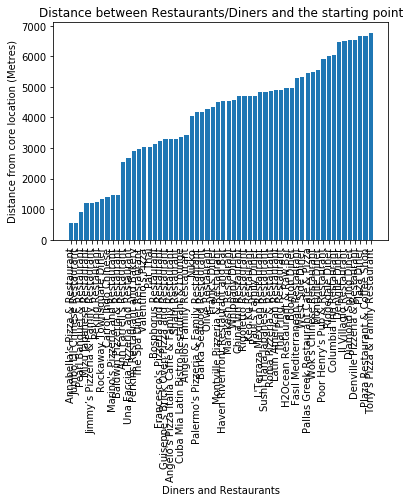

Average distance between Restaurants/Diners and core location is 4051 metres.


In [13]:
def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(distance_diners_df.name))
    plt.bar(distance_diners_df.name, distance_diners_df.distance)
    plt.xlabel('Diners and Restaurants')
    plt.ylabel('Distance from core location (Metres)')
    plt.xticks(distance_diners_df.name, rotation = 90)
    plt.title('Distance between Restaurants/Diners and the starting point')
    plt.show()
plot_bar_x()

print("Average distance between Restaurants/Diners and core location is {} metres.".format(int(sum(diners_df['distance'])/diners_df.shape[0])))

### Few Points to Note:

- Annabella's Pizza and Restaurant is the closest to the core location.
- Tony's Pizza and Restaurant is the farthest from the core location
- The average location between Diners and core location is 4051 meters or Approximately 2 miles.

### 5 Closest Restaurants:
- Annabella's Pizza & Restaurant
- Jumbo LII Chinese Restaurant	
- Pearl Banquet & Restaurant
- Mizu Japanese Restaurant
- Jimmy’s Pizzeria & Family Restaurant	

##  Let's explore the Restaurant's Ratings

In [105]:
#Rating of venues
rating_df=[]

for k in range(diners_df.shape[0]):
    
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(k,CLIENT_ID, CLIENT_SECRET, VERSION)
    
    result = requests.get(url).json()
    #print(result)
    try:
        #print(df_venues.name[k],result['response']['venue']['rating'])
        rating=result['response']['venue']['rating']
        rating_df.append(rating)
        
    except:
        #print(df_venues.name[k],'This venue has not been rated yet.')
        rating='No Rating Yet'
        rating_df.append(rating)

In [106]:
rate_dict = {'Venue': diners_df.name, 'Rating': rating_df,'distance':diners_df.distance}
rate_df=pd.DataFrame(rate_dict)
rate_df

,Venue,Rating,distance
1,The Spa Diner Resraurant,No Rating Yet,2976
3,Whippany Diner,5.4,4566
4,Rockaway Townsquare Diner,No Rating Yet,1344
5,Paul's Family Diner,7.7,4714
6,Ridgedale Diner,No Rating Yet,6025
8,West Side Diner,No Rating Yet,5332
9,Frank's Diner,7.4,4331
11,Diamond Spring Diner,6.6,6527
12,Boonton Diner,No Rating Yet,4956
13,Montville Diner,No Rating Yet,5551


### Droping the venues havig no ratings

In [109]:
only_rated_tips = rate_df[(rate_df['Rating']!='No Rating Yet')]
only_rated_tips

,Venue,Rating,distance
3,Whippany Diner,5.4,4566
5,Paul's Family Diner,7.7,4714
9,Frank's Diner,7.4,4331
11,Diamond Spring Diner,6.6,6527
4,Annabella's Pizza & Restaurant,7.7,553
5,Jumbo LII Chinese Restaurant,7.4,564
6,Pearl Banquet & Restaurant,7.9,922
11,Keo Ku Restaurant,7.7,4693
13,Il Villagio Restaurant,7.5,6507
17,Perkins Restaurant and Bakery,8.2,2898


### Sorting the Venues in descending order by Rating

In [112]:
top_5= only_rated_tips[['Venue','Rating']].sort_values('Rating', ascending= False)
top_5

,Venue,Rating
25,Guiseppe's Brick Oven Pizza and Restaurant,9
17,Perkins Restaurant and Bakery,8.2
35,Fasıl Mediterranean Restaurant,8
49,Tony's Pizza & Family Restaurant,8
6,Pearl Banquet & Restaurant,7.9
4,Annabella's Pizza & Restaurant,7.7
11,Keo Ku Restaurant,7.7
5,Paul's Family Diner,7.7
40,Thai Ping Restaurant,7.7
13,Il Villagio Restaurant,7.5


### The top five best rated restautants are:

- Guiseppe's Brick Oven Pizza and Restaurant
- Perkins Restaurant and Bakery
- Fasıl Mediterranean Restaurant
- Tony's Pizza & Family Restaurant
- Pearl Banquet & Restaurant
    

## Counting the Number of restautants that falls under different category

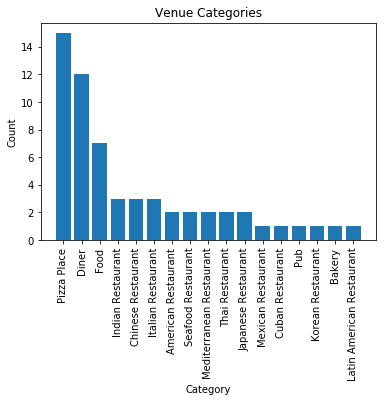

In [103]:
freq_venue=diners_df['categories'].value_counts()
freq_venue=pd.DataFrame(freq_venue).reset_index()
freq_venue.columns=['Category','Count']
freq_venue

def plot_bar_categ():
    # this is for plotting purpose
    index = np.arange(len(freq_venue.Category))
    plt.bar(freq_venue.Category, freq_venue.Count)
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.xticks(freq_venue.Category,rotation=90)
    plt.title('Venue Categories')
    plt.show()
plot_bar_categ()

##### Point to Note:

There are 15 pizza places and 12 diners within 4 miles and rest of all are cuisine restaurants and other food places!


## 3.2 Predictive Modeling

### Clustering based on venues

In [113]:
# one hot encoding
neighbor_onehot = pd.get_dummies(diners_df[['categories']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
neighbor_onehot['name'] = diners_df['name'] 

# move neighborhood column to the first column
fixed_columns = [neighbor_onehot.columns[-1]] + list(neighbor_onehot.columns[:-1])
neighbor_onehot = neighbor_onehot[fixed_columns]

neighbor_onehot.head()

,name,American Restaurant,Bakery,Chinese Restaurant,Cuban Restaurant,Diner,Food,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Pizza Place,Pub,Seafood Restaurant,Thai Restaurant
1,The Spa Diner Resraurant,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,Whippany Diner,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,Rockaway Townsquare Diner,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
5,Paul's Family Diner,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
6,Ridgedale Diner,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [114]:
neighbor_onehot.shape
neighbor_grouped = neighbor_onehot.groupby('name').mean().reset_index()

In [115]:
# Top 10 venues
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['name'] = neighbor_grouped['name']
neighborhoods_venues_sorted 

,name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Angelo's Pizza Italia Caffé & Family Restaurant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Angelos Family Restaurant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Ann Farrell's Restaurant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Annabella's Pizza & Restaurant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Baldwin Pizzeria & Restaurant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Barka Seafood Restaurant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Boonton Diner,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Bosphorus Restaurant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Carrot Indo Chinese,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,China Inn Restaurant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Clustering

In [116]:
# Clustering

# set number of clusters
kclusters = 5

neighbor_grouped_clustering = neighbor_grouped.drop('name', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(neighbor_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 


# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Clusters', kmeans.labels_)

neighbor_merged = diners_df

# merge neighbor_grouped with diners_df to add latitude/longitude for each neighborhood
neighbor_merged = neighbor_merged.join(neighborhoods_venues_sorted.set_index('name'), on='name')

kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

## Finding the center of all clusters and midpoint of all venues

In [117]:
fin=neighbor_merged.groupby(['Clusters']).mean()

lati=sum(fin.lat)/len(fin.lat)
longi=sum(fin.lng)/len(fin.lng)

#Taking midpoint of top ten closest hotel
venues_lan=sum(diners_df.lat)/len(diners_df.lat)
venues_lng=sum(diners_df.lng)/len(diners_df.lng)

final_latitude=(lati+venues_lan)/2
final_longitude=(longi+venues_lng)/2

print("Final location (Green Dot in our below given map) of our brand new restaurant:{},{}".format(final_latitude,final_longitude))

Final location (Green Dot in our below given map) of our brand new restaurant:40.86756915210712,-74.41410530991203


## Predicted Location for Opening new restaurant

In [118]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

folium.CircleMarker(
    [final_latitude, final_longitude],
    radius=10,
    color='green',
    popup='My New Restaurant',
    fill = True,
    fill_color = 'black',
    fill_opacity = 0.6
).add_to(map_clusters)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(neighbor_merged['lat'], neighbor_merged['lng'], neighbor_merged['name'], neighbor_merged['Clusters']):
    label = folium.Popup(str(poi) + ' Clusters ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=6,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

       
map_clusters

## Examine Clusters
Now, we examine each cluster and determine the discriminating venue categories that distinguish each cluster.

### Cluster 1

In [119]:
neighbor_merged.loc[neighbor_merged['Clusters'] == 0, neighbor_merged.columns[[1] + list(range(5, neighbor_merged.shape[1]))]]

,categories,id,Clusters,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,American Restaurant,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Indian Restaurant,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Japanese Restaurant,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,Korean Restaurant,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,Italian Restaurant,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,Pub,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,Bakery,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,Cuban Restaurant,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,Mediterranean Restaurant,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,Seafood Restaurant,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Cluster 2

In [120]:
neighbor_merged.loc[neighbor_merged['Clusters'] == 1, neighbor_merged.columns[[1] + list(range(5, neighbor_merged.shape[1]))]]

,categories,id,Clusters,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Pizza Place,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Pizza Place,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Pizza Place,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Pizza Place,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,Pizza Place,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,Pizza Place,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,Pizza Place,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,Pizza Place,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,Pizza Place,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,Pizza Place,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Cluster 3

In [121]:
neighbor_merged.loc[neighbor_merged['Clusters'] == 2, neighbor_merged.columns[[1] + list(range(5, neighbor_merged.shape[1]))]]

,categories,id,Clusters,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Food,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Food,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Food,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,Food,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,Food,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45,Food,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Cluster 4

In [122]:
neighbor_merged.loc[neighbor_merged['Clusters'] == 3, neighbor_merged.columns[[1] + list(range(5, neighbor_merged.shape[1]))]]

,categories,id,Clusters,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Diner,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Diner,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Diner,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Diner,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Diner,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Diner,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Diner,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,Diner,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,Diner,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,Diner,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Cluster 5

In [123]:
neighbor_merged.loc[neighbor_merged['Clusters'] == 4, neighbor_merged.columns[[1] + list(range(5, neighbor_merged.shape[1]))]]

,categories,id,Clusters,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,Chinese Restaurant,0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,Chinese Restaurant,0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41,Chinese Restaurant,0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



# 4. Results


## 4.1 Top 5 Closest Restaurants

- Annabella's Pizza & Restaurant
- Jumbo LII Chinese Restaurant
- Pearl Banquet & Restaurant
- Mizu Japanese Restaurant
- Jimmy’s Pizzeria & Family Restaurant


#### The average distance between all the restaurants and core location i.e., Sheraton Hotel is approximately 2 miles.


## 4.2.  5 Top  Rated Venues

- Guiseppe's Brick Oven Pizza and Restaurant
- Perkins Restaurant and Bakery
- Fasıl Mediterranean Restaurant
- Tony's Pizza & Family Restaurant
- Pearl Banquet & Restaurant

Here, Pearl Banquet and Restaurant (Category: Indian Restaurant) is the third closest restaurant which is only 900 meter away from the core location and it has rating 7.9/10 which also falls under 5 top-rated restaurant. Therefore, Pearl Banquet and Restaurant could be the best place nearby.


### 4.2 New Restaurant Location

Final location is pointed at 40.86607251706134,-74.41305574615026

This location is nearby Sheraton Hotel, our core location, which is also in the middle of many firms and phamaceutical companies.


### 4.3 Spot for the new Restaurant
- Green - spot for new restaurant
- Red - Sheraton Hotel Parsippany
- Blue - restaurants/diners
- My predicted location and core location are very close to each other which is expected.As this has central attraction,the predicted one almost matched with the core.

In [124]:
new_location = folium.Map(location=[latitude, longitude], zoom_start=16) # generate map centred around parsippany


# add a red circle marker to represent the new location for opening restaurant
folium.CircleMarker(
    [final_latitude, final_longitude],
    radius=10,
    color='green',
    popup='New Restaurant',
    fill = True,
    fill_color = 'green',
    fill_opacity = 0.6
).add_to(new_location)


# add a red circle marker to represent the Sheraton Hotel
folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Sheraton Hotel',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(new_location)

# add existed restaurants as blue circle markers
for lat, lng, label in zip(diners_df.lat, diners_df.lng, diners_df.name):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(new_location)
    
    
markers_colors = []
for lat, lon, poi, cluster in zip(neighbor_merged['lat'], neighbor_merged['lng'], neighbor_merged['name'], neighbor_merged['Clusters']):
    label = folium.Popup(str(poi) + ' Clusters ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=6,
        popup=label,
        color='blue',
        fill=True,
        fill_color='black',
        fill_opacity=0.7).add_to(new_location)


# display map
new_location


# 5. Discussion

The top-rated restaurants could be the best for the working-class people who work nearby to grab lunch everyday as it is easily accessible from their office within 2 miles location.

Enteprenuers who are interested to start a new food service business could set up a restaurant on a predicted spot. This will bring revenue automatically as the location is spotted in the area where 1000s of people commute to and work all day.

As mentioned earlier, most of data needs to be extracted from googlemaps. Even though we got somewhat accurate prediction. To be very confident on concluding our output, we may need more data to analyze.

Research based on reviews and restaurant menus could be used for future purpose.


# 6. Conclusion

The top-rated restaurants could be the best for the working-class people who work nearby to grab lunch everyday as it is easily accessible from their office within 2 miles location.

Enteprenuers who are interested to start a new food service business could set up a restaurant on a predicted spot. This will bring revenue automatically as the location is spotted in the area where 1000s of people commute to and work all day.

As mentioned earlier, most of data needs to be extracted from googlemaps. Even though we got somewhat accurate prediction. To be very confident on concluding our output, we may need more data to analyze.

Research based on reviews and restaurant menus could be used for future purpose.



##### This notebook is developed by [Savyata Regmi]('https://www.linkedin.com/in/savyata-regmi-6ba625113/') as the capstone project for IBM Data Science Professional Certificate offered by [Coursera.org]('https://www.coursera.org/').